# Simple Proof of Concept

This is a prototype, a proof of concept. The goal is to show some possibilities of what can be done with the data, rather than to present a ready-made solution.

The implementation uses the simplest possible approach in terms of signal processing, making a series of assumptions that make the implementation easier, while acknowledging that these assumptions are likely to be objectively wrong. The hope is that they are not too far off, and the analysis still makes sense.

We aim to cluster, using evidential methods, the activities realized by a post-CVA patient in the interval of a week. We have two bracelets that provide accelerometry data.

In this notebook:
- We extract the data from both bracelets and sincronize them.
- We partition this data in 5 minutes intervals
- We filter off the "non-activity" parts of the signal, representing mostly the patient's sleeping time.
- We project each window of this signal into a 2D space that, we hope, represents the most interesting information
- Using evidential clustering we group this data
- We try to extract useful statistics from this clustering

### Our main Assumptions

We will consider, for the analysis, only the norm of the acceleration and will not be concerned by the distribution in $X$, $Y$ and $Z$.

Let our data be $\mathbf{s} \in S^T$ with $S = \mathbb{R^2}$ our space state and $T$ is our time index, seven days of data with a small sampling $\Delta t$.

Fixing a smaller (here, five minutes) time index $\tilde T$ with the same sampling size, we take $W = \left\lfloor \frac{|T|}{|\tilde T|} \right \rfloor$ small portions of the data $\mathbf{s} = [\mathbf{s}^1 \ ... \ \mathbf{s}^{W}]$ with all $\mathbf{s}^i \in S^{\tilde T}$.

For each $\mathbf{s}_i$ interval we assume that we are handling a realization of a stochastic process that is stationary in the strong sense. That is:
- $\forall i \in \{1, ..., W\} \exists p_i$ probabilities distribution such that $\mathbf{s}^i \sim p_i$.

We assume that we can properly approach each $p_i$ as a binormal distribution and that the mean value for both is always around 1, the gravity effect.

For clustering, then, we consider each arms acceleration norm std.

The reasons for making this choice:
- Ease of analysis
- Norms seem to always be in fact around 1 (or at least not more than 10% away)
- Considering just two features make the problem easy to visualize and explain

Some evident limitations of this approach:
- We do not take into account the time behaviour between the windows or within them
- We don't consider the correlation between the arms inside each frame
- Even if we effectivelly had this strong stationarity, we are not considering any higher-moment neither the interaction between the axis.

## Clustering the Data

Based on this simplified approach, an evidential clustering is performed, dividing the data into 3 clusters. We try proposing an interpretation and, taking advantage of the belief (lower bound) and plausibility (upper bound), estimate the time spent in each cluster. 

## Remarks

- The main advantage of this type of analysis
    - It allows a personalized treatment approach, with the clusters bringing metrics that are exclusive to the analysing the individual patient.
        - That is, the tracking of the evolution of patient and the treatment proposed can be adapted to their needs.
- The main problem of this type of analysis
    - It allows a personalized treatment approach, with the clusters bringing metrics that are exclusive to the analysing the individual patient.
        - That is, it is not trivial to compare one patient to another.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime

from openmovement.load import CwaData

## Data extraction Using `openmovement` library

In [3]:
def extract_data(filename):
    with CwaData(filename, include_gyro=True, include_temperature=True) as cwa_data:
        # As an ndarray of [time,accel_x,accel_y,accel_z,temperature]
        sample_values = cwa_data.get_sample_values()
        space_values = sample_values[:, 1:4]
        norms = np.linalg.norm(space_values, axis=1)
        space_values = np.column_stack((space_values, norms))
        time_index = sample_values[:, 0]
        
        # As a pandas DataFrame
        samples = cwa_data.get_samples()

    return {
        'filename': filename,
        'space_values': space_values,
        'time_index': time_index,
        'df': samples
    }

def extract_patient(pt_number):
    # load the data
    non_paretic = extract_data(f'data/ReArm_{pt_number}_ac_np.cwa')
    paretic = extract_data(f'data/ReArm_{pt_number}_ac_p.cwa')

    # remove the beginning of the earlier dataset to make the start times match
    start = max(non_paretic['time_index'][0], paretic['time_index'][0])

    non_paretic['space_values'] = non_paretic['space_values'][non_paretic['time_index'] >= start]
    non_paretic['time_index'] = non_paretic['time_index'][non_paretic['time_index'] >= start]

    paretic['space_values'] = paretic['space_values'][paretic['time_index'] >= start]
    paretic['time_index'] = paretic['time_index'][paretic['time_index'] >= start]

    # remove the end of the longer dataset to make the lengths match
    length = min(non_paretic['time_index'].shape[0], paretic['time_index'].shape[0])
    
    non_paretic['space_values'] = non_paretic['space_values'][:length]
    non_paretic['time_index'] = non_paretic['time_index'][:length]

    paretic['space_values'] = paretic['space_values'][:length]
    paretic['time_index'] = paretic['time_index'][:length]

    # define the time index
    time_index = (non_paretic['time_index'] + paretic['time_index']) / 2

    space_values = np.stack((non_paretic['space_values'], paretic['space_values']), axis=1)
    
    return space_values, time_index

In [4]:
patient_id = "C1P08_20210810_1"
# patient_id = "C1P13_20211110_1"
space_values, time_index = extract_patient(patient_id)

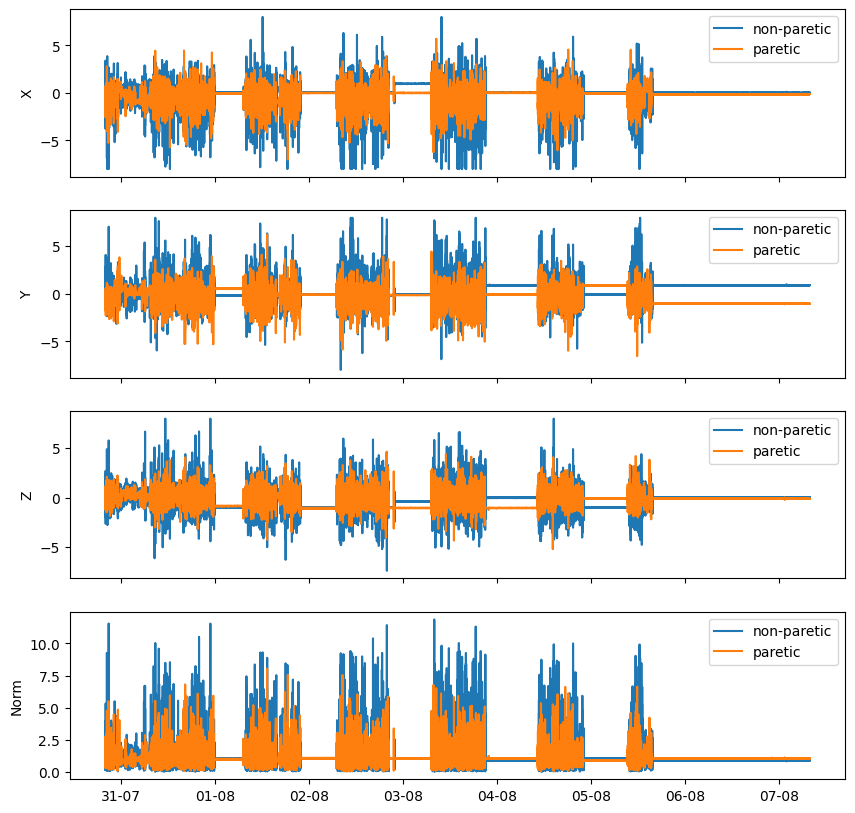

In [5]:
fig, ax = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

for i in range(4):
    ax[i].plot(pd.to_datetime(time_index, unit='s'), space_values[:, 0, i], label='non-paretic')
    ax[i].plot(pd.to_datetime(time_index, unit='s'), space_values[:, 1, i], label='paretic')
    ax[i].set_ylabel(['X', 'Y', 'Z', 'Norm'][i])
    ax[i].legend(loc='upper right')

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m'))
plt.show()

In [6]:
# export the accelerometer data
fig.savefig('figs/accelerometer_time.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [7]:
space_values.shape

(32669316, 2, 4)

## Data partition

In [8]:
def partition(space_values, time_index, minutes_per_window=5):
    delta_t = float(np.diff(time_index).mean())

    number_timepoints = space_values.shape[0]
    number_arms = space_values.shape[1]
    number_axis= space_values.shape[2]

    # partition the data into windows
    window_size = int(minutes_per_window * 60 / delta_t)
    num_windows = number_timepoints // window_size

    print(f"delta_t: {delta_t}")
    print(f"window_size: {window_size}")
    print(f"num_windows: {num_windows}")

    space_values = space_values[:num_windows * window_size]
    space_values = space_values.reshape((num_windows, window_size, number_arms, number_axis))

    time_index = time_index[:num_windows * window_size]
    time_index = time_index.reshape((num_windows, window_size))
    
    return space_values, time_index

In [9]:
windows, time_indexes = partition(space_values, time_index)

delta_t: 0.019807240904446525
window_size: 15145
num_windows: 2157


In [10]:
windows.shape

(2157, 15145, 2, 4)

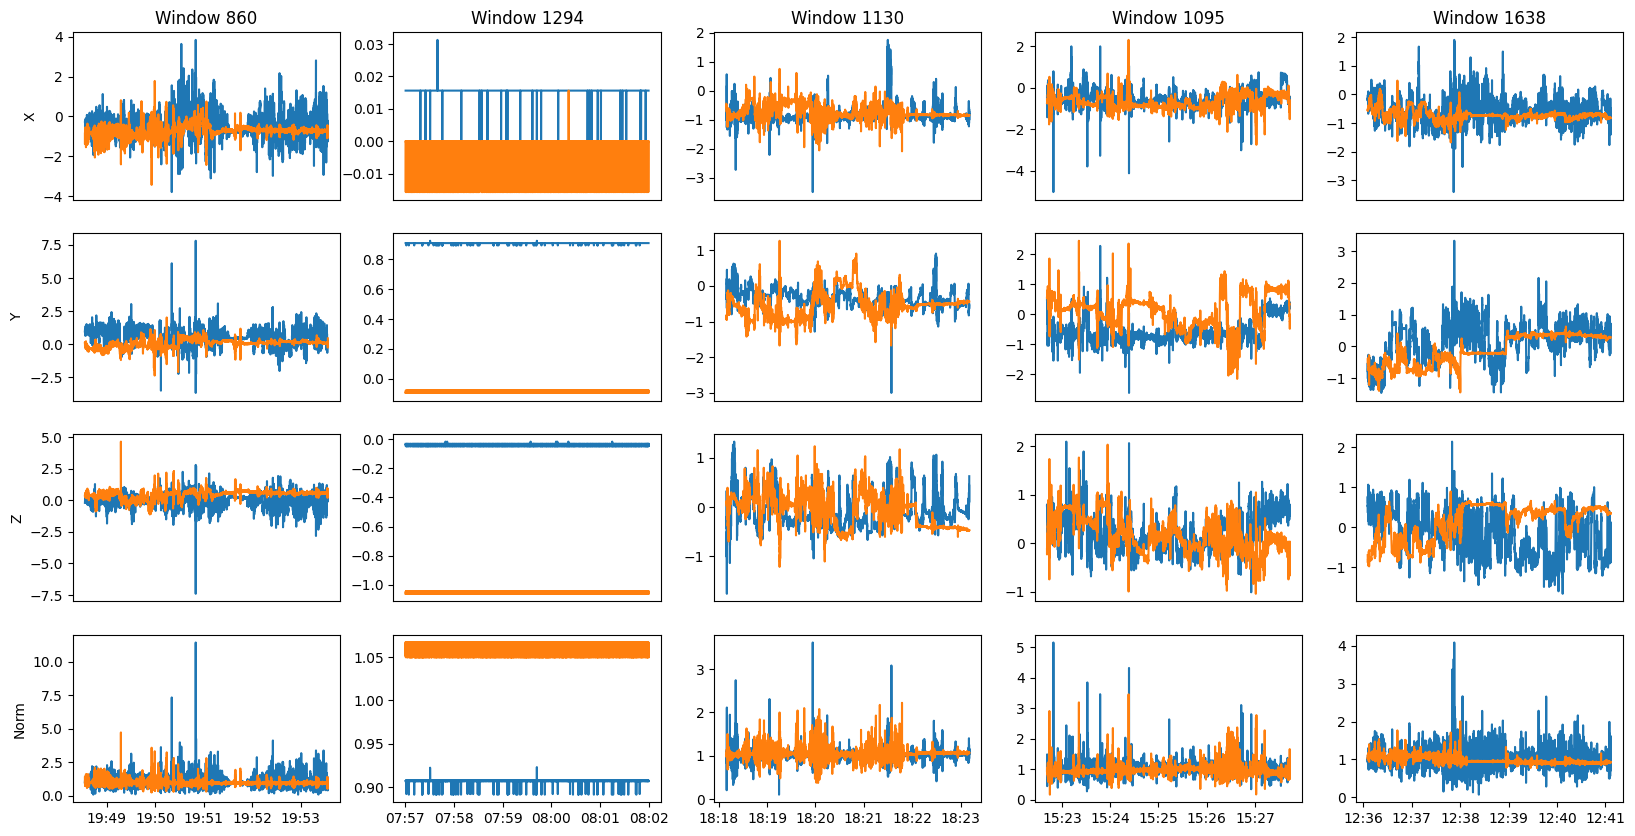

In [11]:
# plot 5 random windows
np.random.seed(42)
fig, axs = plt.subplots(4, 5, figsize=(20, 10))

for j in range(5):
    idx = np.random.randint(0, windows.shape[0])
    for i in range(4):
        pd_time_index = pd.to_datetime(time_indexes[idx], unit='s')
        axs[i, j].plot(pd_time_index, windows[idx, :, 0, i], label='non-paretic')
        axs[i, j].plot(pd_time_index, windows[idx, :, 1, i], label='paretic')
        if  i == 3:
            axs[i, j].xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
        else:
            axs[i, j].set_xticks([])
            if i == 0:
                axs[i, j].set_title(f"Window {idx}")
        if j == 0:
            axs[i, j].set_ylabel(['X', 'Y', 'Z', 'Norm'][i])
        #axs[j, i].legend(loc='upper right')
        #axs[i, j].legend(loc='upper right')

In [12]:
# export the windows
fig.savefig('figs/some_windows.eps', format='eps')

In [13]:
windows.shape

(2157, 15145, 2, 4)

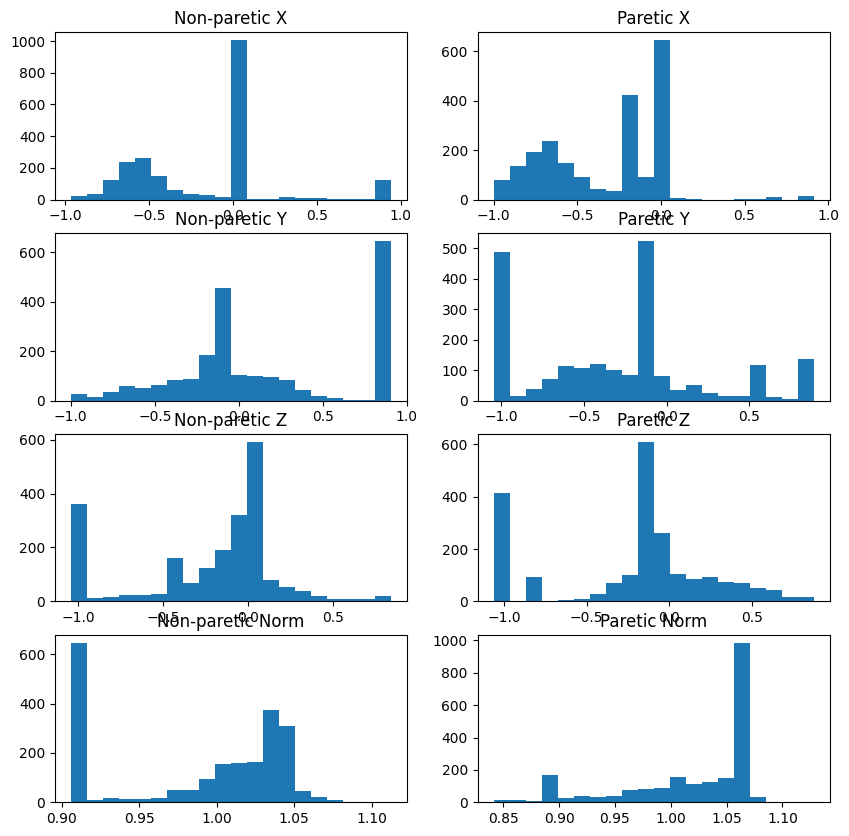

In [14]:
# get each window's mean
means = windows.mean(axis=1)

# histogram of the means
fig, axs = plt.subplots(4, 2, figsize=(10, 10))

for i in range(4):
    axs[i, 0].hist(means[:, 0, i], bins=20)
    axs[i, 0].set_title(f"Non-paretic {['X', 'Y', 'Z', 'Norm'][i]}")
    axs[i, 1].hist(means[:, 1, i], bins=20)
    axs[i, 1].set_title(f"Paretic {['X', 'Y', 'Z', 'Norm'][i]}")

plt.show()

## Filter sleeping periods

In [15]:
# detect the windows with low variance in all axes
def detect_low_variance(windows, threshold=0.1):
    variances = np.var(windows, axis=1)
    variances = np.sum(variances, axis=(1, 2))
    
    return variances < threshold

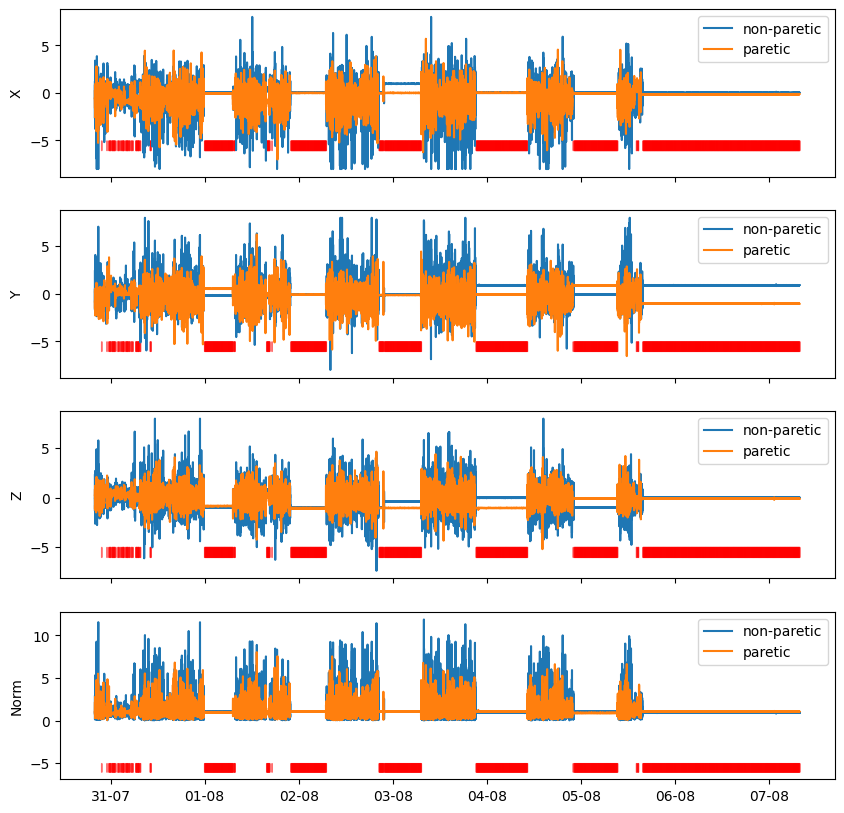

In [16]:
low_vars = detect_low_variance(windows, threshold=0.01)

fig, ax = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

for i in range(len(time_indexes)):
    if low_vars[i]:
        for j in range(4):
            ax[j].fill_between(pd.to_datetime(time_indexes[i], unit='s'), -6, -5, color='red', alpha=0.5)

for i in range(4):
    ax[i].plot(pd.to_datetime(time_index, unit='s'), space_values[:, 0, i], label='non-paretic')
    ax[i].plot(pd.to_datetime(time_index, unit='s'), space_values[:, 1, i], label='paretic')
    ax[i].set_ylabel(['X', 'Y', 'Z', 'Norm'][i])
    ax[i].legend(loc='upper right')

plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m'))
plt.show()

In [17]:
# export the inactive detection
fig.savefig('figs/inactive_detection.png', format='png')

In [18]:
# remove the windows with low variance
windows_cleaned = windows[~low_vars]
time_indexes_cleaned = time_indexes[~low_vars]

## Features Extraction


In [19]:
def extract_features(window):
    features = []
    for j in range(2):
        for i in range(4):
            if i == 3:
                features.append(np.std(window[:, j, i]))
    return np.array(features)

In [20]:
features = np.array([extract_features(window) for window in windows_cleaned])
features.shape

(979, 2)

## Clustering

In [21]:
# ECM clustering
from evclust.ecm import ecm
number_clusters = 3
#model = ecm(x=features, c=number_clusters, beta = 1.3,  alpha=1, delta=3, disp=False)
model = ecm(x=features, c=number_clusters, beta = 1.3,  alpha=2.2, delta=3, disp=False)

In [22]:
F = model['F']
focal_sets = [" \\cup ".join(["\\omega_{" + str(i+1) + "}" for i in range(len(f)) if f[i] == 1]) for f in F]
focal_sets[0] = "\emptyset"
mass_focal_sets = ['$m_{'+focal_sets[i]+'}$' for i in range(len(focal_sets))]
focal_sets = ['$'+f+'$' for f in focal_sets]

mass = model['mass']

In [23]:
F

array([[0., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 1., 0.],
       [0., 0., 1.],
       [1., 0., 1.],
       [0., 1., 1.],
       [1., 1., 1.]])

In [24]:
features.shape

(979, 2)

In [25]:
start_wi, end_w = time_indexes_cleaned[:, 0], time_indexes_cleaned[:, -1]

ecm_df = pd.DataFrame({'start': pd.to_datetime(start_wi, unit='s'), 'end': pd.to_datetime(end_w, unit='s'), 'non-paretic_std': features[:, 0], 'paretic_std': features[:, 1]})
for i in range(len(focal_sets)):
    f = int(sum([F[i][k] * 2**k for k in range(len(F[i]))]))
    ecm_df[str(f)] = mass[:, i]

# export the ECM results
ecm_df.to_csv(f'clustering_results/{patient_id}_ecm.csv', index=False)

In [26]:
ecm_df

,start,end,non-paretic_std,paretic_std,0,1,2,3,4,5,6,7
0,2021-07-30 20:00:07.512469529,2021-07-30 20:05:08.754674435,0.237100,0.105886,4.662937e-15,0.000095,4.664262e-07,3.866274e-08,9.995360e-01,3.675150e-04,5.738868e-07,5.114187e-08
1,2021-07-30 20:05:08.774562836,2021-07-30 20:10:09.882629871,0.185309,0.115084,1.280087e-13,0.910540,6.807841e-05,2.445440e-05,6.840549e-03,8.181527e-02,3.792462e-04,3.328869e-04
2,2021-07-30 20:10:09.902511120,2021-07-30 20:15:11.001961946,0.145736,0.054008,5.655476e-13,0.011520,1.144265e-02,3.722164e-03,1.018072e-03,4.456465e-05,9.716918e-01,5.611075e-04
3,2021-07-30 20:15:11.021849155,2021-07-30 20:20:12.220299244,0.132589,0.078040,9.439116e-13,0.110207,2.319083e-02,7.247597e-01,1.278904e-03,1.045037e-04,1.346143e-01,5.844526e-03
4,2021-07-30 20:20:12.240186214,2021-07-30 20:25:13.378952742,0.167425,0.094302,2.153833e-14,0.031631,4.232823e-05,3.853222e-05,2.815040e-04,1.134769e-04,5.665410e-03,9.622273e-01
...,...,...,...,...,...,...,...,...,...,...,...,...
974,2021-08-05 15:16:36.639656544,2021-08-05 15:21:37.517231941,0.068223,0.053842,5.329071e-15,0.000009,9.999754e-01,1.508111e-05,4.008363e-07,1.182861e-08,3.493732e-07,1.206680e-08
975,2021-08-05 15:21:37.537093401,2021-08-05 15:26:38.214397430,0.059463,0.001275,6.961098e-14,0.000015,9.999788e-01,3.296778e-06,2.306888e-06,4.067353e-08,8.411334e-07,2.093867e-08
976,2021-08-05 15:26:38.234250784,2021-08-05 15:31:38.880528927,0.025735,0.001667,1.168510e-12,0.000112,9.998523e-01,1.554008e-05,1.662068e-05,2.825107e-07,3.369942e-06,1.069369e-07
977,2021-08-05 15:31:38.900377750,2021-08-05 15:36:39.417139053,0.113355,0.002372,4.141354e-12,0.002655,9.953103e-01,6.115729e-04,6.618397e-04,1.119182e-05,7.415706e-04,8.915068e-06


/var/folders/qn/sypqqw3101v1k6_70wqyd99h0000gn/T/ipykernel_80428/1014412982.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')


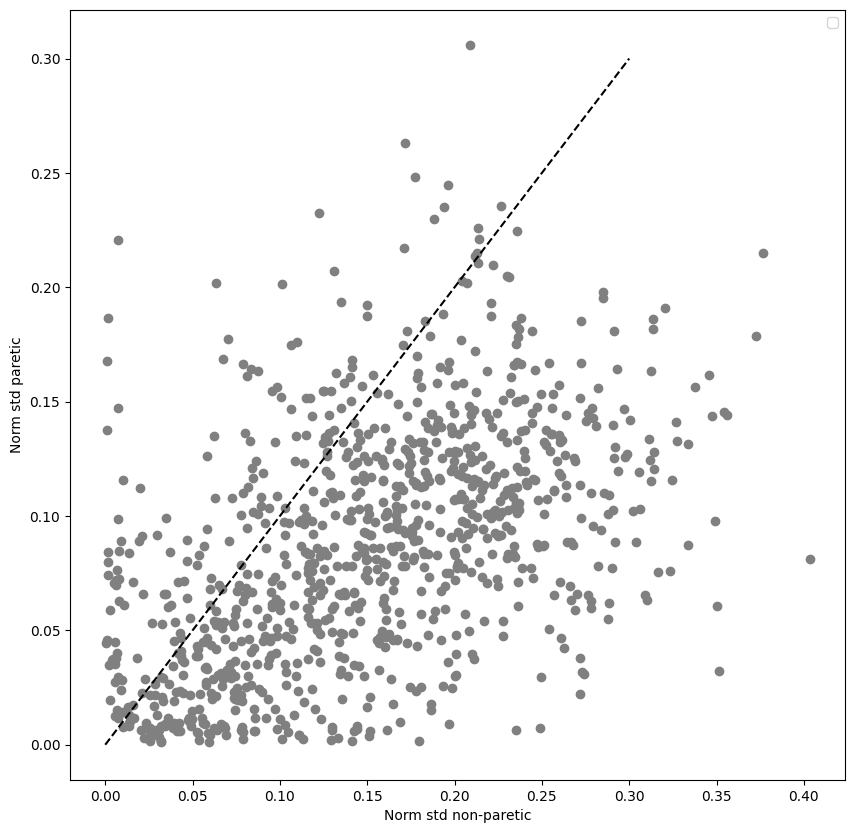

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for i in range(len(features)):
    ax.scatter(features[i, 0], features[i, 1], color='grey')

# make dashed lines where stds are equal
ax.plot([0, 0.3], [0, 0.3], 'k--')

ax.legend(loc='upper right')

ax.set_xlabel('Norm std non-paretic')
ax.set_ylabel('Norm std paretic')

plt.show()

In [28]:
# get list of colors 
cmap = plt.get_cmap('Pastel1')
focal_colors = [np.array(cmap(i)) for i in range(len(focal_sets))]
colors = []
for point in range(len(features)):
    color = np.sum([focal_colors[i] * mass[point, i] for i in range(len(focal_sets))], axis=0)
    color = np.clip(color, 0, 1)
    color = color[:3]
    colors.append(color)

In [29]:
#export the non-paretic vs paretic stds
fig.savefig('figs/non_paretic_vs_paretic.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


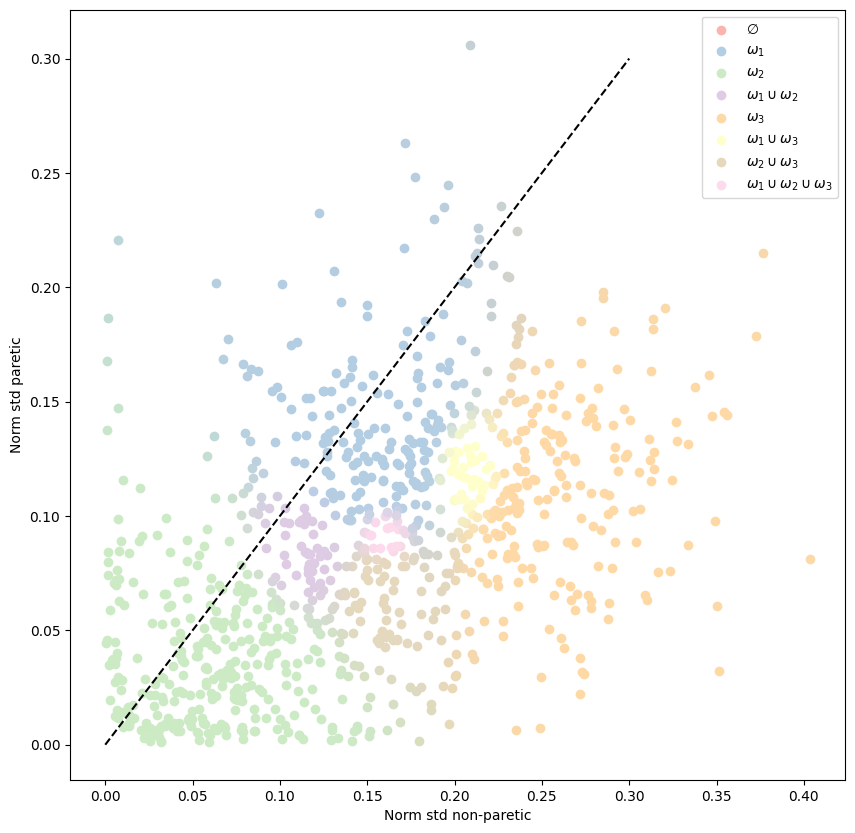

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for i in range(len(features)):
    ax.scatter(features[i, 0], features[i, 1], color=colors[i])

for i in range(len(focal_sets)):
    ax.scatter([], [], color=focal_colors[i], label=focal_sets[i])

# make dashed lines where stds are equal
ax.plot([0, 0.3], [0, 0.3], 'k--')

ax.legend(loc='upper right')

ax.set_xlabel('Norm std non-paretic')
ax.set_ylabel('Norm std paretic')

plt.show()

In [31]:
# export the clustering
fig.savefig('figs/clustering.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


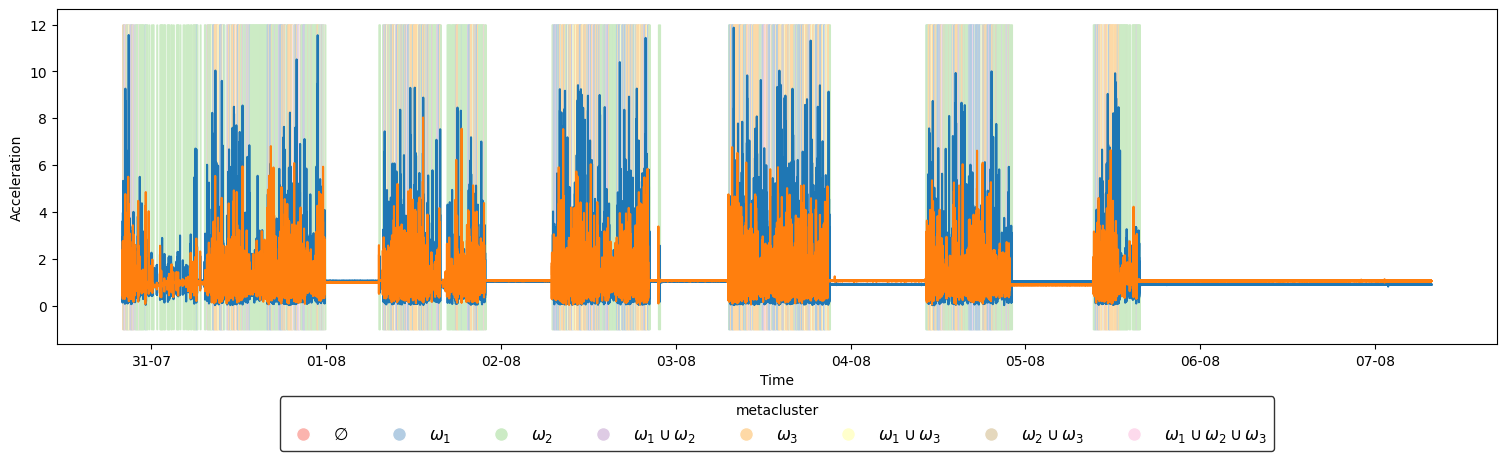

In [32]:
fig, ax = plt.subplots(figsize=(15, 5))

norms = space_values[:, :, 3]

# make ax occupy the whole width
fig.subplots_adjust(left=0.02, right=0.98, top=0.9, bottom=0.23)

for i in range(len(time_indexes_cleaned)):
    ax.fill_between(pd.to_datetime(time_indexes_cleaned[i], unit='s'), -1, 12, color=colors[i])

# plot the data
ax.plot(pd.to_datetime(time_index, unit='s'), norms)

ax.set_xlabel('Time')
ax.set_ylabel('Acceleration')
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m'))

fig.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=focal_sets[i], 
                               markerfacecolor=cmap(i), markersize=10) for i in range(len(focal_sets))], edgecolor='black', 
                               loc='lower center', ncol=len(focal_sets), fontsize='large', title='metacluster', bbox_to_anchor=(0.5, 0))

plt.show()


In [33]:
#export the clustering
fig.savefig('figs/clustering_time.png', format='png')

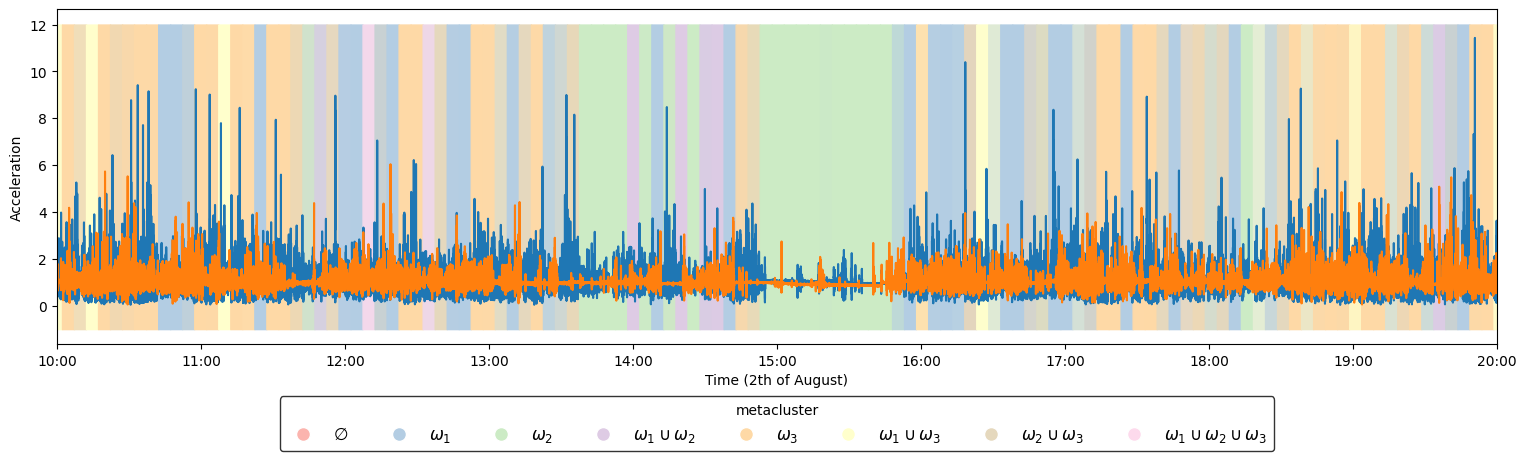

In [34]:
fig, ax = plt.subplots(figsize=(15, 5))

norms = space_values[:, :, 3]

# make ax occupy the whole width
fig.subplots_adjust(left=0.02, right=0.98, top=0.9, bottom=0.23)

for i in range(len(time_indexes_cleaned)):
    ax.fill_between(pd.to_datetime(time_indexes_cleaned[i], unit='s'), -1, 12, color=colors[i])

# plot the data
ax.plot(pd.to_datetime(time_index, unit='s'), norms)

ax.set_ylabel('Acceleration')

# focus on a specific time period: 10h to 20h, 2th of August
ax.set_xlim(datetime.datetime(2021, 8, 2, 10), datetime.datetime(2021, 8, 2, 20))
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M'))
ax.set_xlabel('Time (2th of August)')

fig.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', label=focal_sets[i], 
                               markerfacecolor=cmap(i), markersize=10) for i in range(len(focal_sets))], edgecolor='black', 
                               loc='lower center', ncol=len(focal_sets), fontsize='large', title='metacluster', bbox_to_anchor=(0.5, 0))

fig.savefig('figs/clustering_zoomed.png', format='png')

plt.show()

In [35]:
centroids = []
for i in range(len(focal_sets)):
    centroid = np.zeros(features.shape[1])
    for point in range(len(features)):
        centroid += features[point] * mass[point, i]
    centroid /= np.sum(mass[:, i])

    if np.sum(F[i]) == 1 or True:
        print(f"Metacluster {focal_sets[i]}")
        print(f"Centroid: {centroid}")
    
    centroids.append(centroid)

Metacluster $\emptyset$
Centroid: [0.18906495 0.18399906]
Metacluster $\omega_{1}$
Centroid: [0.15881137 0.13832489]
Metacluster $\omega_{2}$
Centroid: [0.06380979 0.03796178]
Metacluster $\omega_{1} \cup \omega_{2}$
Centroid: [0.11225629 0.08339956]
Metacluster $\omega_{3}$
Centroid: [0.25600239 0.10847111]
Metacluster $\omega_{1} \cup \omega_{3}$
Centroid: [0.20789704 0.11938487]
Metacluster $\omega_{2} \cup \omega_{3}$
Centroid: [0.16052312 0.06056848]
Metacluster $\omega_{1} \cup \omega_{2} \cup \omega_{3}$
Centroid: [0.16096896 0.09211424]


In [36]:
model['g']

array([[0.15866927, 0.13902037],
       [0.06313643, 0.03307544],
       [0.25803622, 0.1030022 ]])

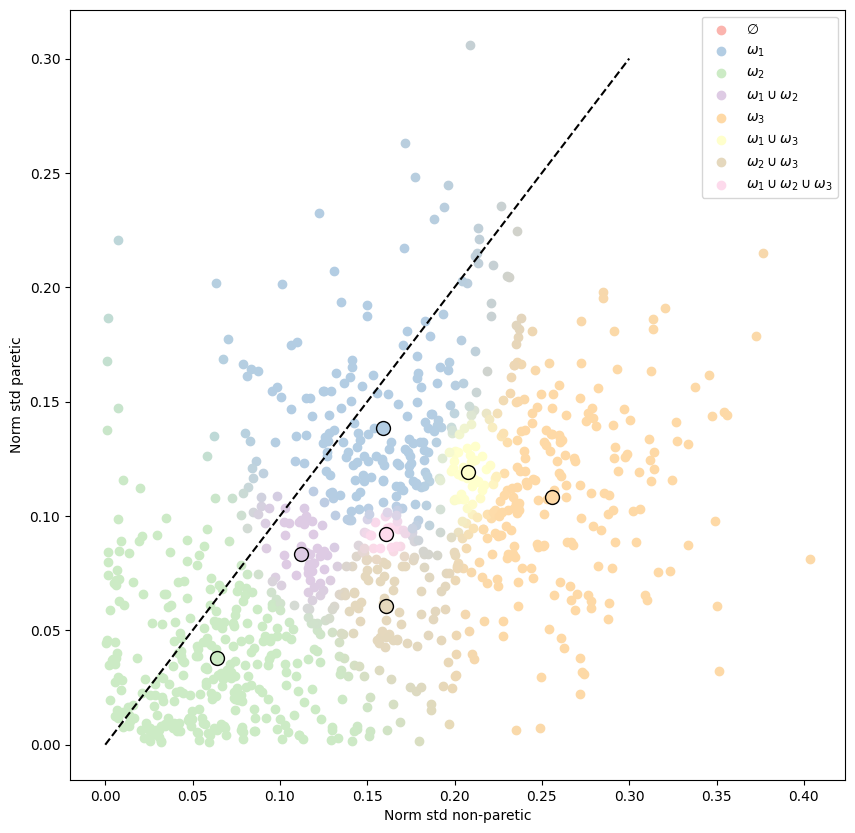

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for i in range(len(features)):
    ax.scatter(features[i, 0], features[i, 1], color=colors[i])

for i in range(len(focal_sets)):
    ax.scatter([], [], color=focal_colors[i], label=focal_sets[i])

for i in range(1, len(centroids)):
    ax.scatter(centroids[i][0], centroids[i][1], color=focal_colors[i], s=100, edgecolors='black')

# make dashed lines where stds are equal
ax.plot([0, 0.3], [0, 0.3], 'k--')

ax.legend(loc='upper right')

ax.set_xlabel('Norm std non-paretic')
ax.set_ylabel('Norm std paretic')

plt.show()

In [38]:
# export the clustering with centroids
fig.savefig('figs/clustering_centroids.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [39]:
num_intervals = features.shape[0]

In [40]:
belief_points = [[
    j for j in range(len(features)) if np.sum(model['Ynd'][j]) == 1 and model['Ynd'][j, i] == 1
] for i in range(number_clusters)]

print({i: len(belief_points[i])/num_intervals for i in range(number_clusters)})

{0: 0.20633299284984677, 1: 0.33094994892747703, 2: 0.24004085801838612}


In [41]:
plaus_points = [[
    j for j in range(len(features)) if model['Ynd'][j, i] == 1
] for i in range(number_clusters)]

print({i: len(plaus_points[i])/num_intervals for i in range(number_clusters)})

{0: 0.41062308478038817, 1: 0.4964249233912155, 2: 0.4065372829417773}


[0.32438955]


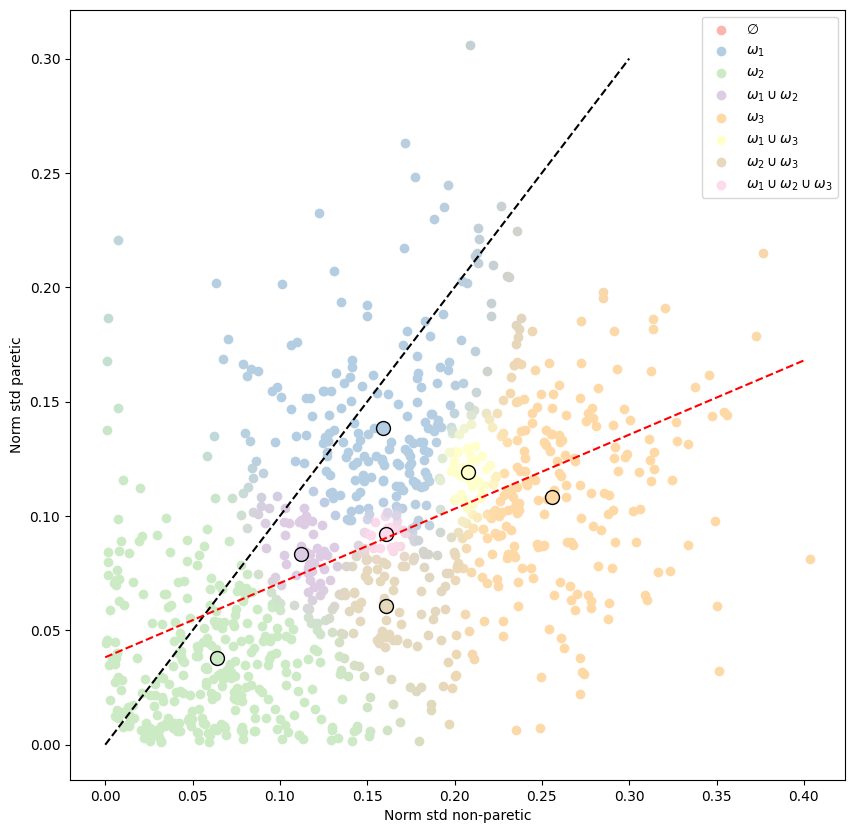

In [42]:
# linear regression
from sklearn.linear_model import LinearRegression

X = features[:, 0].reshape(-1, 1)
y = features[:, 1]

linear_model = LinearRegression()
linear_model.fit(X, y)

print(linear_model.coef_)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for i in range(len(features)):
    ax.scatter(features[i, 0], features[i, 1], color=colors[i])

for i in range(len(focal_sets)):
    ax.scatter([], [], color=focal_colors[i], label=focal_sets[i])

for i in range(1, len(centroids)):
    ax.scatter(centroids[i][0], centroids[i][1], color=focal_colors[i], s=100, edgecolors='black')

# make dashed lines where stds are equal
ax.plot([0, 0.3], [0, 0.3], 'k--')

# plot the linear regression
x = np.linspace(0, 0.4, 100)
y = linear_model.predict(x.reshape(-1, 1))
ax.plot(x, y, 'r--')

ax.legend(loc='upper right')

ax.set_xlabel('Norm std non-paretic')
ax.set_ylabel('Norm std paretic')

plt.show()

## Hard and fuzzy clustering

In [43]:
# K-means clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=number_clusters, max_iter=20, random_state=42)
kmeans_labels = kmeans.fit_predict(features)

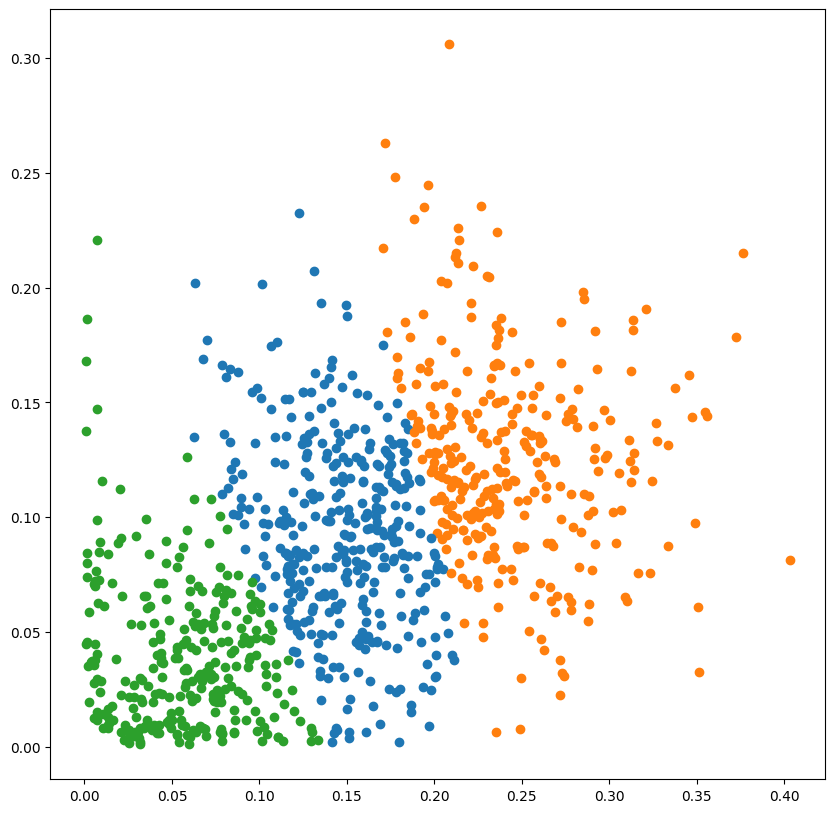

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

hard_cmap = plt.get_cmap('tab10')

for i in range(len(features)):
    ax.scatter(features[i, 0], features[i, 1], color=hard_cmap(kmeans_labels[i]))
    
plt.show()

In [45]:
features

array([[0.23709988, 0.10588627],
       [0.18530894, 0.11508433],
       [0.14573606, 0.05400847],
       ...,
       [0.0257349 , 0.00166666],
       [0.11335528, 0.00237165],
       [0.10139315, 0.00256347]])

In [46]:
# Fuzzy C-means clustering
from fcmeans import FCM
fcm = FCM(n_clusters=number_clusters, random_state=42)
fcm.fit(features)
fcm_labels = fcm.predict(features)
fcm_centers = fcm.centers
fcm_membership = fcm.u

In [47]:
fuzzy_cmap = plt.get_cmap('tab10')

fuzzy_ref_colors = [np.array(fuzzy_cmap(i)) for i in range(number_clusters)]
fuzzy_colors = []
for point in range(len(features)):
    color = np.sum([fuzzy_ref_colors[i] * fcm_membership[point, i] for i in range(number_clusters)], axis=0)
    color = np.clip(color, 0, 1)
    color = color[:3]
    fuzzy_colors.append(color)

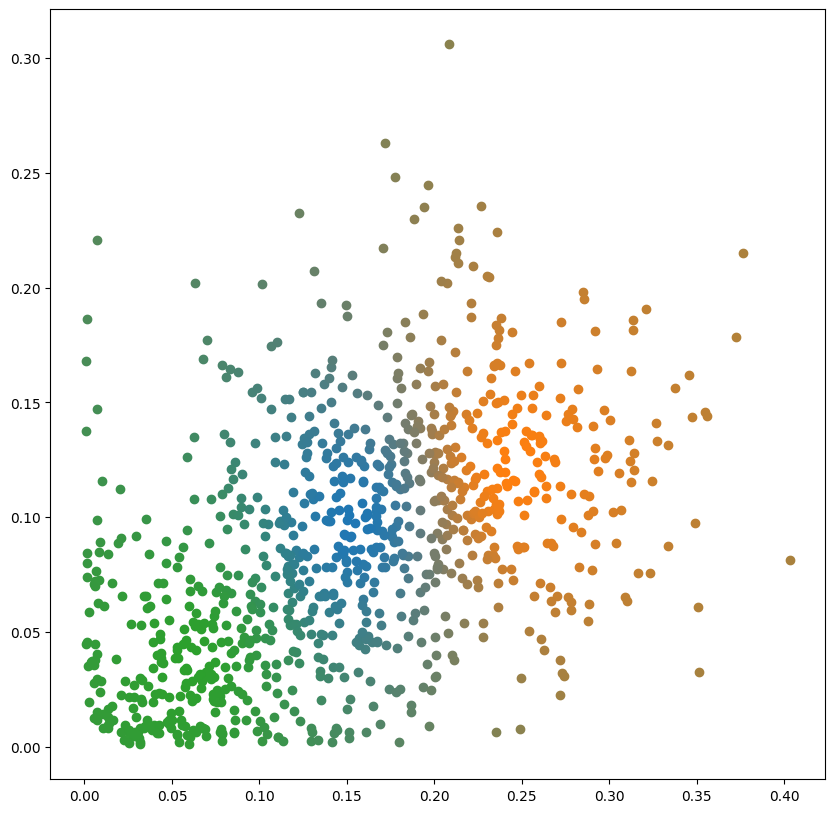

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for i in range(len(features)):
    ax.scatter(features[i, 0], features[i, 1], color=fuzzy_colors[i])